In [1]:
# Install required package
import sys
# !{sys.executable} -m pip install --user --upgrade steam-nb-api
!{sys.executable} -m pip install --user --upgrade -i https://test.pypi.org/simple/ steam-nb-api 

import os
from pathlib import Path
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.lines as lines

from copy import *
from steam_nb_api.ledet.ParametersLEDET import ParametersLEDET
from steam_nb_api.utils import misc
from steam_nb_api.roxie_parser import MagneticCoil
from steam_nb_api.utils.SelfMutualInductanceCalculation import SelfMutualInductanceCalculation

from steam_nb_api.roxie_parser import CableDatabase
from steam_nb_api.roxie_parser import ConductorPosition
from steam_nb_api.roxie_parser.geometricFunctions import close_pairs_ckdtree, close_pairs_pdist

%load_ext autoreload
%autoreload 2

Looking in indexes: https://test.pypi.org/simple/
     |████████████████████████████████| 296kB 6.5MB/s eta 0:00:01
  Found existing installation: steam-nb-api 0.3.400
    Uninstalling steam-nb-api-0.3.400:
ERROR: Could not install packages due to an EnvironmentError: [Errno 2] No such file or directory: '/eos/home-m/mjanitsc/.local/lib/python3.7/site-packages/steam_nb_api-0.3.400.dist-info/'



# Global variables

In [2]:
nameMagnet = 'MQMC_2in1'
paramLEDET = ParametersLEDET()

# Define style for plots
selectedFont = {'fontname':'DejaVu Sans', 'size':14}

# If this variable is set to True, many comments will be displayed
verbose = True

# Generate magnet geometry parsing .data and .cadata files

VERSION 10.2.1
'LHC MQM/MQMC/MQML insertion quadrupole, 1.9K and 4.5K                              '
'../datab/roxie.bhdata                                                              '
'../datab/roxie.cadata                                                              '
'MQM_2D_Iron.iron                                                                   '

&OPTION
  LEND=F     LWEDG=F    LPERS=F    LQUENCH=F  LALGO=F    LQUENCH0D=F
  LMIRIRON=F LBEMFEM=T  LPSI=F     LSOLV=F    LIRON=T    LMORPH=F   
  LHARD=F    LPOSTP=F   LPEAK=T    LINMARG=F  LMARG=F    LSELF=T    
  LMQE=F     LINDU=F    LEDDY=F    LSOLE=F    LFLUX=F    LFIELD3=F  
  LFISTR=F   LSELF3=F   LBRICK=F   LLEAD=F    LVRML=F    LOPERA=F   
  LOPER20=F  LANSYS=F   LRX2ANS=F  LANS2RX=F  LDXF=F     LMAP2D=T   
  LMAP3D=F   LEXPR=F    LFIL3D=F   LFIL2D=F   LCNC=F     LANSYSCN=F 
  LWEIRON=F  LCATIA=F   LEXEL=T    LQVOLT=F   LAXIS=T    LIMAGX=F   
  LIMAGY=F   LRAEND=F   LMARKER=F  LROLER2=F  LROLERP=F  LIMAGZZ=F  
  LSUPP=F  

<IPython.core.display.Javascript object>


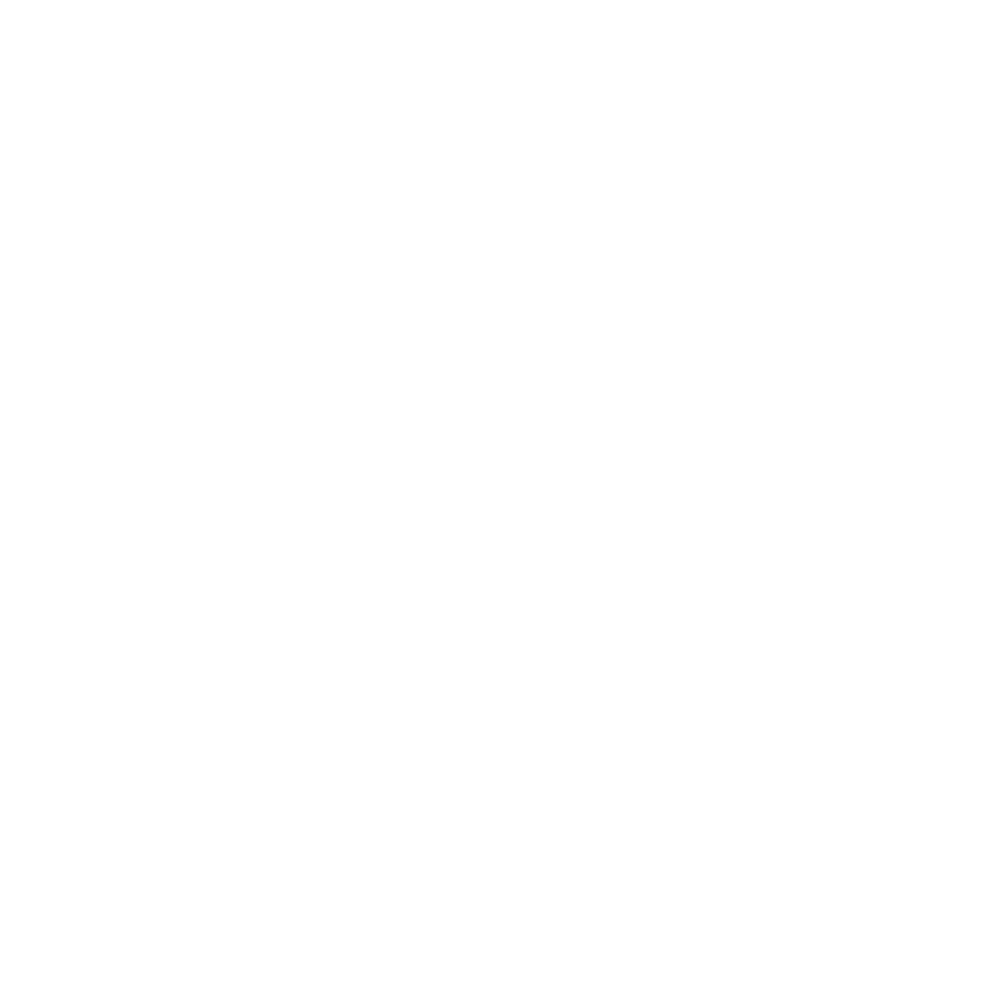

In [3]:
# Select ROXIE .cadata file with conductor data
currentDirectory = Path(os.path.split(os.getcwd())[0])
fileNameCadata = os.path.join(currentDirectory,'resources','roxie.cadata')
# fileNameCadata ='roxie.cadata'
fileNameData = nameMagnet + '_All_WithIron_WithSelfField.data'

# Define the magnetic coil
definedMagneticCoil = MagneticCoil.MagneticCoil()
xPos, yPos, iPos, xBarePos, yBarePos, xS, yS, iS = definedMagneticCoil.generateCoilGeometry(fileNameData, fileNameCadata, verbose=verbose)

# Plot conductors and their numbers
%matplotlib notebook
f = plt.figure(2, figsize=(10, 10))
# Plot edges
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r', edgecolor='k', alpha=.25)
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='b', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)

    # Plot conductor numbers
    x_ave_cond, y_ave_cond = sum(cXPos) / len(cXPos), sum(cYPos) / len(cYPos)
    plt.text(x_ave_cond, y_ave_cond, '{}'.format(c + 1))

# Plot edges of bare conductors
for c, (cXBarePos, cYBarePos) in enumerate(zip(xBarePos, yBarePos)):
    pt1, pt2, pt3, pt4 = (cXBarePos[0], cYBarePos[0]), (cXBarePos[1], cYBarePos[1]), (cXBarePos[2], cYBarePos[2]), (
    cXBarePos[3], cYBarePos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=False, facecolor='r', edgecolor='k', alpha=.25)
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=False, facecolor='b', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)

plt.xlabel('x [m]', **selectedFont)
plt.ylabel('y [m]', **selectedFont)
plt.title('Conductors and their numbers', **selectedFont)
plt.set_cmap('jet')
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
plt.grid()


# Field maps from ROXIE

Total number of strands in the field-map from ROXIE = 20736
Peak magnetic field in the field-map from ROXIE = 6.476670078057087 T


<IPython.core.display.Javascript object>


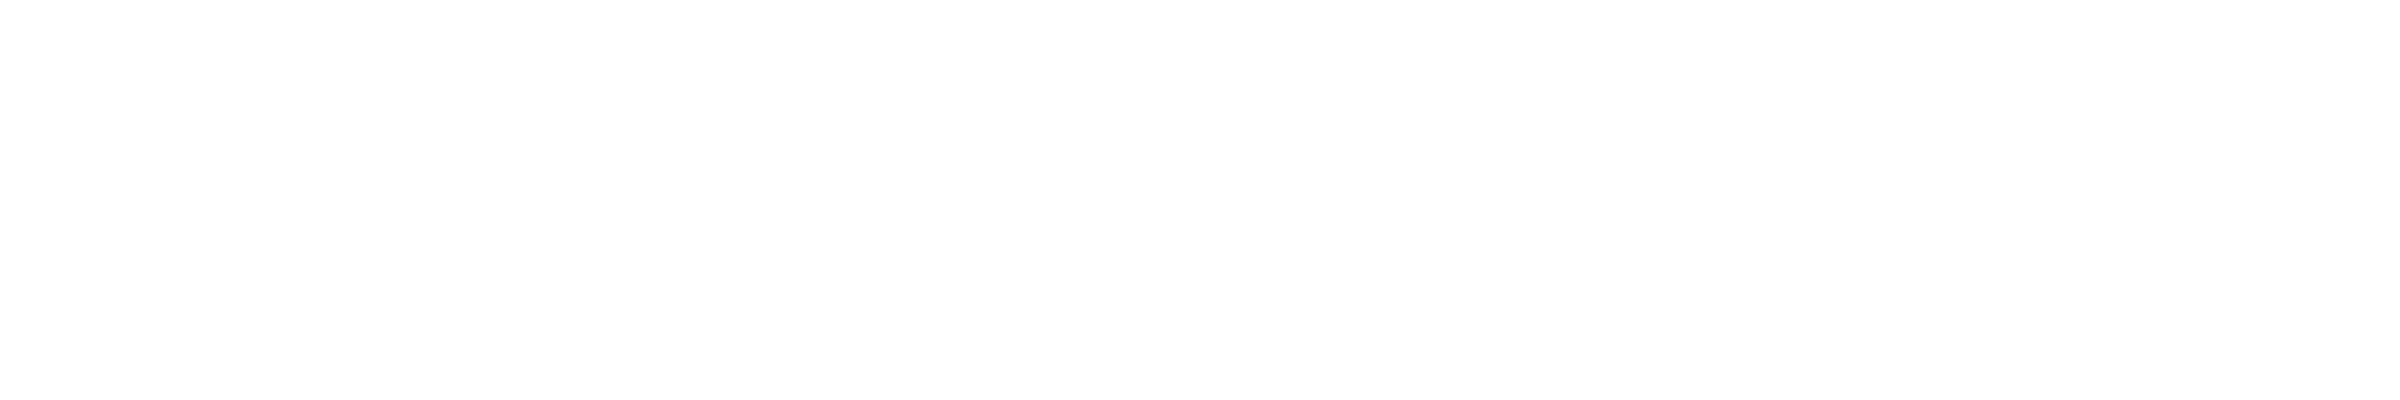

In [4]:
# Acquire data from ROXIE .map2d file
fileName = nameMagnet + '_All_WithIron_WithSelfField.map2d'
headerLines = 1

strandToGroup = np.array([])
strandToHalfTurn = np.array([])
idx = []
x = []
y = []
Bx = []
By = []
Area = []
I = []
fillFactor = []

# Read file
file = open(fileName, "r")
fileContent = file.read()

# Separate rows
fileContentByRow = fileContent.split("\n")

for index in range(len(fileContentByRow)-1):
    if index>headerLines:
        fc = fileContentByRow[index]
        row = fc.split()
#         print(index)
#         print(row)
        strandToGroup = np.hstack([strandToGroup,int(row[0])])
        strandToHalfTurn = np.hstack([strandToHalfTurn,int(row[1])])
        idx = np.hstack([idx,float(row[2])])
        x = np.hstack([x,float(row[3])/1000]) # in [m]
        y = np.hstack([y,float(row[4])/1000]) # in [m]
        Bx = np.hstack([Bx,float(row[5])])
        By = np.hstack([By,float(row[6])])
        Area = np.hstack([Area,float(row[7])])
        I = np.hstack([I,float(row[8])])
        fillFactor = np.hstack([fillFactor,float(row[9])])

nStrandsFieldMap = len(strandToGroup)
print('Total number of strands in the field-map from ROXIE = {}'.format(nStrandsFieldMap))

# Calculate absolute magnetic field
B = []
for i in range(nStrandsFieldMap):
    B = np.hstack([B, (Bx[i]**2+By[i]**2)**.5 ])
print('Peak magnetic field in the field-map from ROXIE = {} T'.format(np.max(B)))

# Plot strand currents and magnetic field
f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x, y, s=2, c=I)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Strand currents',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Current per strand [A]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x, y, s=2, c=Bx)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field X',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x, y, s=2, c=By)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field Y',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field Y [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x, y, s=2, c=B)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field |B|',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()


# Manipulate imported strand positions

Total number of strands = 20736
Total number of half-turns = 576
Total number of turns = 288
Total number of groups = 64


<IPython.core.display.Javascript object>


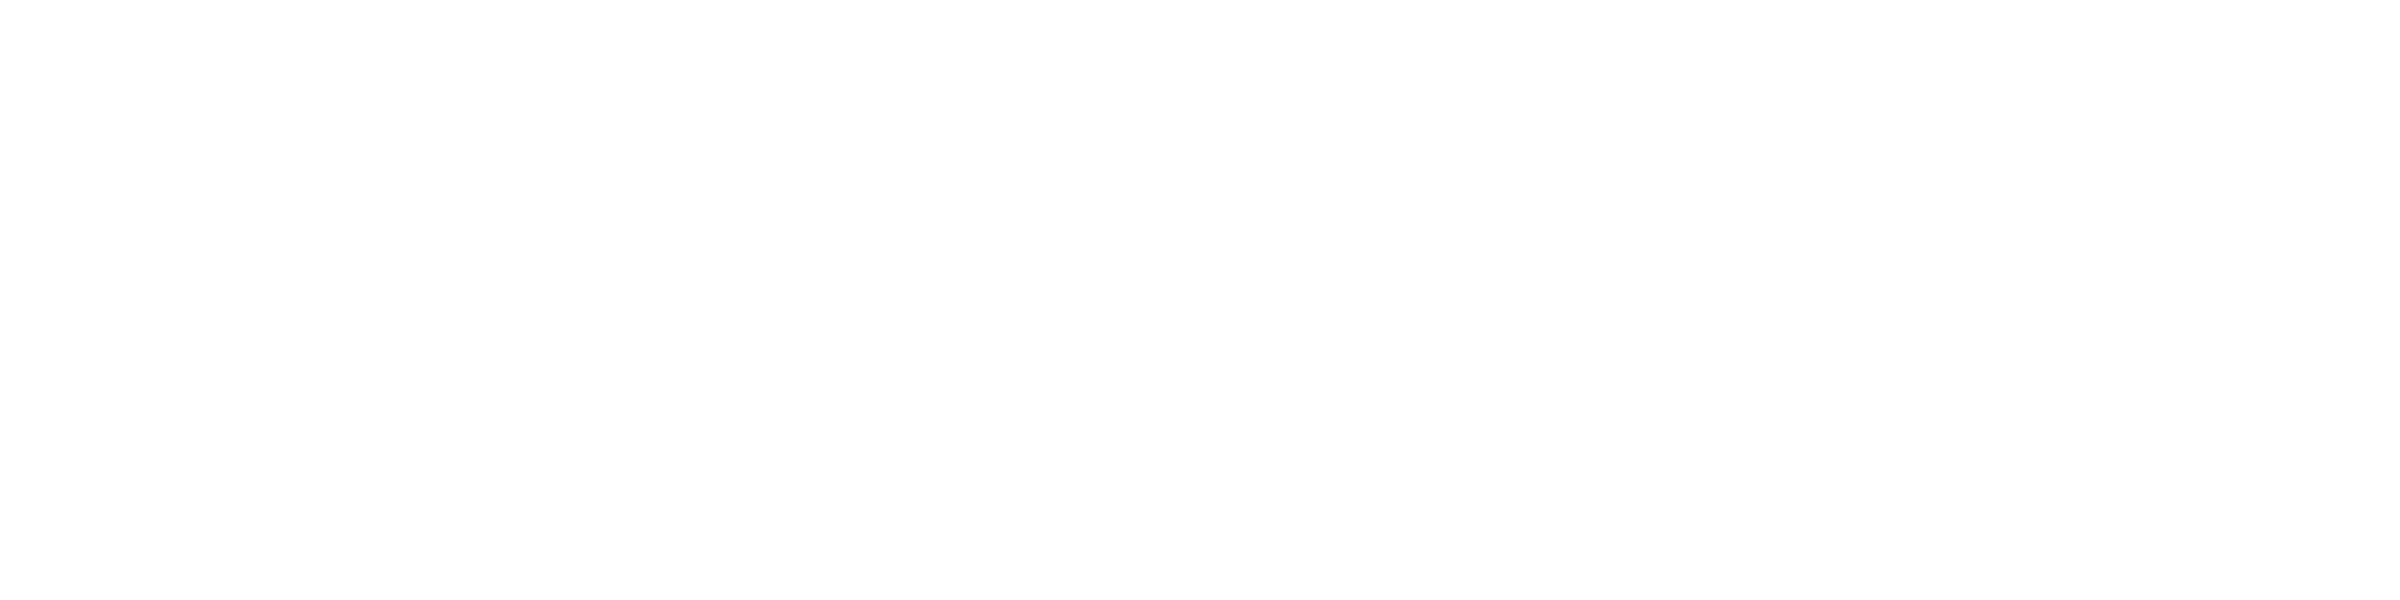

In [5]:
# Number of strands in each half-turn
nStrands = len(strandToGroup)
polarities = np.sign(I);
nHalfTurns = int(np.max(strandToHalfTurn));
nTurns = int(nHalfTurns/2)
nGroups = int(np.max(strandToGroup));
nS = []
for ht in range(1,nHalfTurns+1):
    #nS =sum(strandToHalfTurn==ht);
    nS = np.hstack([ nS, np.size(np.where(strandToHalfTurn==ht)) ]) # Number of strands in each half-turn
nS = np.int_(nS)

strandToGroup = np.int_(strandToGroup)
strandToHalfTurn = np.int_(strandToHalfTurn)
halfTurnToTurn=np.tile(np.arange(1,nTurns+1),2);

# Average half-turn positions
x_ave = []
y_ave = []
for ht in range(1,nHalfTurns+1):
    x_ave = np.hstack([ x_ave, np.mean( x[np.where(strandToHalfTurn==ht)] )])
    y_ave = np.hstack([ y_ave, np.mean( y[np.where(strandToHalfTurn==ht)] )])

# Average group positions
x_ave_group = []
y_ave_group = []
for g in range(1,nGroups+1):
    x_ave_group = np.hstack([ x_ave_group, np.mean( x[np.where(strandToGroup==g)] )])
    y_ave_group = np.hstack([ y_ave_group, np.mean( y[np.where(strandToGroup==g)] )])
    
print('Total number of strands = ' + str(nStrands))
print('Total number of half-turns = ' + str(nHalfTurns))
print('Total number of turns = ' + str(nTurns))
print('Total number of groups = ' + str(nGroups))


# Plot strand currents and magnetic field
%matplotlib notebook
f = plt.figure(figsize=(24,6))
plt.subplot(1, 4, 1 )
plt.scatter(x, y, s=2, c=strandToHalfTurn)
for ht in range(nHalfTurns):
    plt.text(x_ave[ht], y_ave[ht], '{}'.format(ht + 1))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToHalfTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Half-turn [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x, y, s=2, c=strandToGroup)
for g in range(nGroups):
    plt.text(x_ave_group[g], y_ave_group[g], '{}'.format(g + 1))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x_ave, y_ave, s=2, c=halfTurnToTurn)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('halfTurnToTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Turn [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x_ave, y_ave, s=2, c=nS)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Number of strands per half-turn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Number of  strands per cable [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

<IPython.core.display.Javascript object>


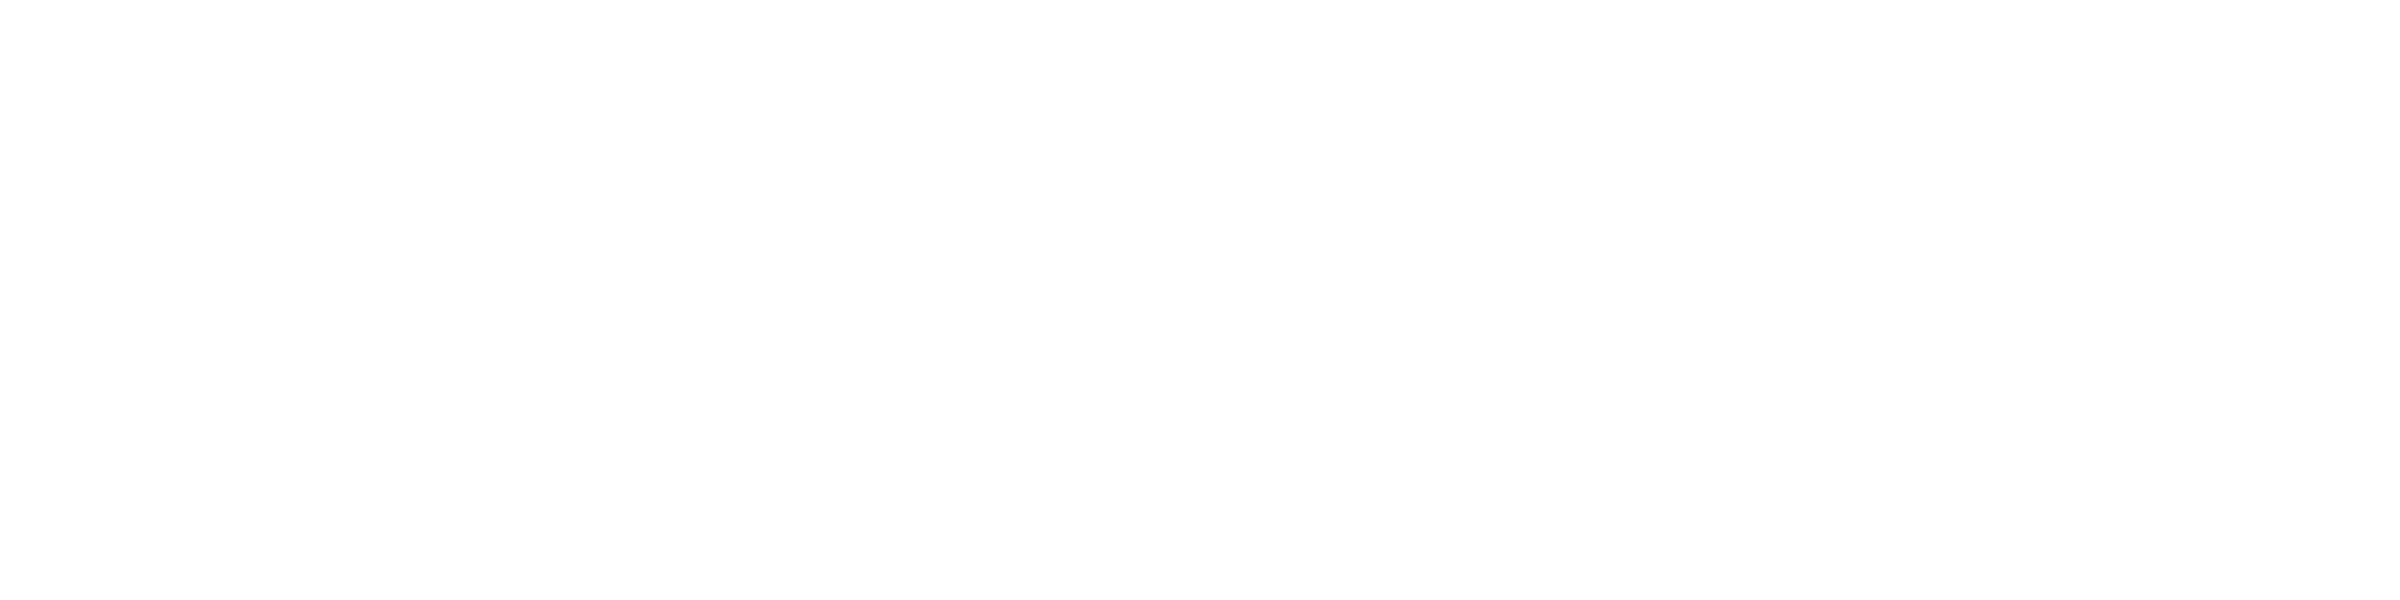

576


In [6]:
f = plt.figure(figsize=(24,6))
plt.subplot(1, 4, 1 )
plt.scatter(x, y, s=2, c=strandToHalfTurn)
for ht in range(nHalfTurns):
    plt.text(x_ave[ht], y_ave[ht], '{}'.format(ht + 1))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToHalfTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Half-turn [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
print(nHalfTurns)

# Overall magnet variables

In [7]:
T00 = 1.9
l_magnet = 2.4
I00 = 5390
Iref = 5390

# Definition of groups of conductors

2 coil sections defined.
64 groups defined.


<IPython.core.display.Javascript object>


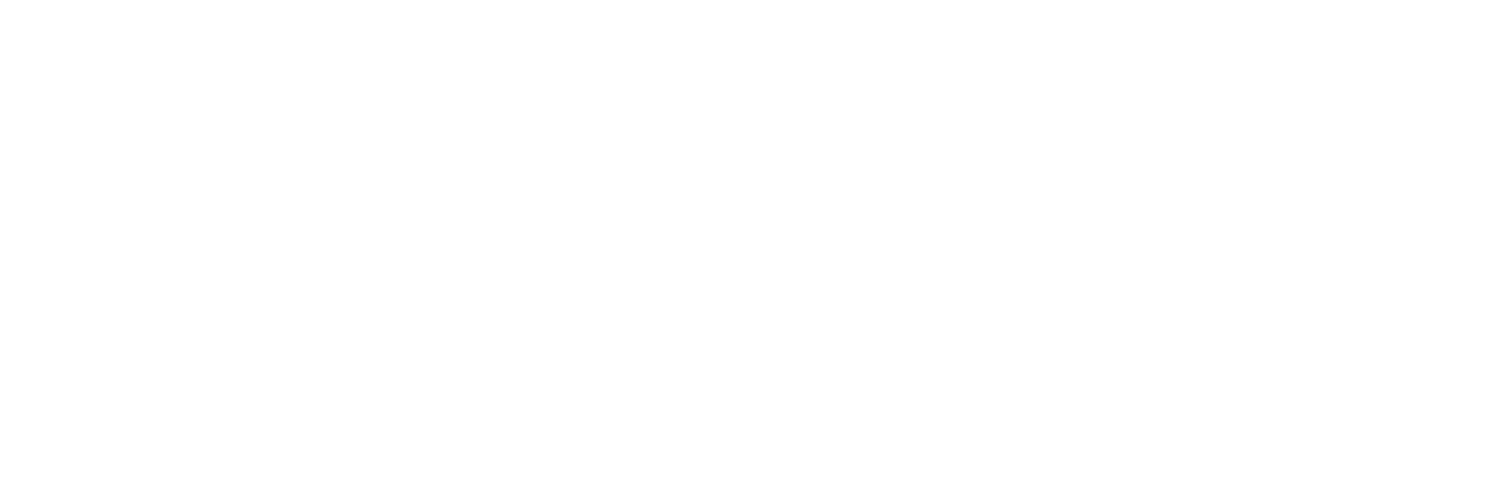

(-0.1574317680964818,
 0.1574317680964818,
 -0.0507317680964818,
 0.0507317680964818)

In [8]:
GroupToCoilSection = int(nGroups/4) * [1] + int(nGroups/4) * [2] + int(nGroups/4) * [1] + int(nGroups/4) * [2]
polarities_inGroup = 4* (4* [+1] + 4* [-1]) + 4* (4* [-1] + 4* [+1])

# Count number of groups defined
nCoilSectionsDefined = np.max(GroupToCoilSection)
nGroupsDefined = len(GroupToCoilSection)

print(str(nCoilSectionsDefined) + ' coil sections defined.')
print(str(nGroupsDefined) + ' groups defined.')


# Plot defined current polarities
polarities_inStrand = np.zeros((1, nStrands), dtype=int)
polarities_inStrand = polarities_inStrand[0]
for g in range(1,nGroupsDefined+1):
    polarities_inStrand[np.where(strandToGroup==g)] = polarities_inGroup[g-1]
    
   

f = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(x, y, s=2, c=polarities_inStrand)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Defined polarities',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Polarity [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1,2,2)
# Plot edges
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r')
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='b')
    plt.gca().add_line(line)
plt.xlabel('x [m]', **selectedFont)
plt.ylabel('y [m]', **selectedFont)
plt.title('Expected polarities', **selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Polarity [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

# Conductor properties in each group

In [9]:
#### Number of half-quadrants
nHalfQuadrants = 16
nGroupsPerQuadrant = 4

# Number of half-turns in each group
nT = nHalfQuadrants * [10, 5, 13, 8]
# Number of strands in each cable belonging to a particular group
nStrands_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [36]
# length of each half turn [m] (default=l_magnet)
l_mag_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [l_magnet]
# strand diameter [m]
ds_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [0.480E-3]
# filament diameter [m]
df_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [6E-6]
# fraction of superconductor in the strands
f_SC_strand_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [1/(1+1.75)]
# Effective transverse resistivity parameter (default=1)
f_ro_eff_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [1]
# Filament twist-pitch [m]
Lp_f_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [0.015]
# RRR of the conductor in each group of cables
RRR_Cu_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [100 /293*273]
# type of superconductor (1=Nb-Ti, 2=Nb3Sn(Summer's fit), 3=BSCCO2212, 4=Nb3Sn(Bordini's fit))
SCtype_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [1]
# type of stabilizer (1=Cu, 2=Ag)
STtype_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [1]
# Type of cable insulation (1=G10, 2=kapton)
insulationType_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [2]
# Type of filler of voids between adjacent strands (1=G10, 2=kapton, 3=helium, 4=void)
internalVoidsType_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [3]
# Type of filler of voids between strands and insulation layers (1=G10, 2=kapton, 3=helium, 4=void)
externalVoidsType_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [2]
# bare cable width [m]
wBare_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [8.80E-3]
# bare average cable height [m]
hBare_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [(0.78E-3+0.91E-3)/2]
# insulation thickness in the width direction [m]
wIns_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [80E-6]
# insulation thickness in the height direction [m]
hIns_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [80E-6]
# Strand twist-pitch [m]
Lp_s_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [66E-3]
# Cross-contact resistance [Ohm]
R_c_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [100E-6]
# Tc0_NbTi_ht_inGroup [K]
Tc0_NbTi_ht_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [9.2]
# Bc2_NbTi_ht_inGroup [T]
Bc2_NbTi_ht_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [14.5]
# c1_Ic_NbTi_inGroup [A]
c1_Ic_NbTi_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [27444.0]
# c2_Ic_NbTi_inGroup [A/T]
c2_Ic_NbTi_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [-2198.5]
# Tc0_Nb3Sn [K]
Tc0_Nb3Sn_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [0]
# Bc2_Nb3Sn [T]
Bc2_Nb3Sn_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [0]
# Jc_Nb3Sn0 [A*T^0.5/m^2] Based on short-sample measurements
Jc_Nb3Sn0_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [0]

# Jc fit parameters - Based on Arjan's file 
fitParameters_inGroup = np.array([[9.2, 14.5, 754.420, -57.277, 2101.181, 1.361, 8350.450, 12.007]] *  nHalfQuadrants * nGroupsPerQuadrant).transpose() 
# Jc fit type (only used for persistent-current calculation): 1= Jc=constant; 2= Nb-Ti Bottura; 3= Nb-Ti CUDI ; 4= Nb3Sn Summer
selectedFit_inGroup =  nHalfQuadrants * nGroupsPerQuadrant * [3]

nHalfTurnsDefined = np.sum(nT)
print(str(nHalfTurnsDefined) + ' half-turns defined.')
print('')
#  Scale up or down the contribution of heat exchange through the short side of the cables (useful to change the insulation between coil layers
insulationBetweenLayers = 200E-6
insulationAroundCables = 80E-6
fScaling_Pex_AlongHeight_Defined = (2*insulationAroundCables)/(2*insulationAroundCables + insulationBetweenLayers)
print('fScaling_Pex_AlongHeight_Defined = ')
print(fScaling_Pex_AlongHeight_Defined)

# Add Helium fraction
paramLEDET.localsParser(locals())
paramLEDET.setHeliumFraction(4)

576 half-turns defined.

fScaling_Pex_AlongHeight_Defined = 
0.4444444444444445


# Electrical order of the half-turns

The half-turns of these pairs of groups will be connected electrically:
[[3, 35], [4, 36], [2, 34], [1, 33], [13, 45], [14, 46], [16, 48], [15, 47], [5, 37], [6, 38], [8, 40], [7, 39], [11, 43], [12, 44], [10, 42], [9, 41], [19, 51], [20, 52], [18, 50], [17, 49], [29, 61], [30, 62], [32, 64], [31, 63], [21, 53], [22, 54], [24, 56], [23, 55], [27, 59], [28, 60], [26, 58], [25, 57]]


<IPython.core.display.Javascript object>


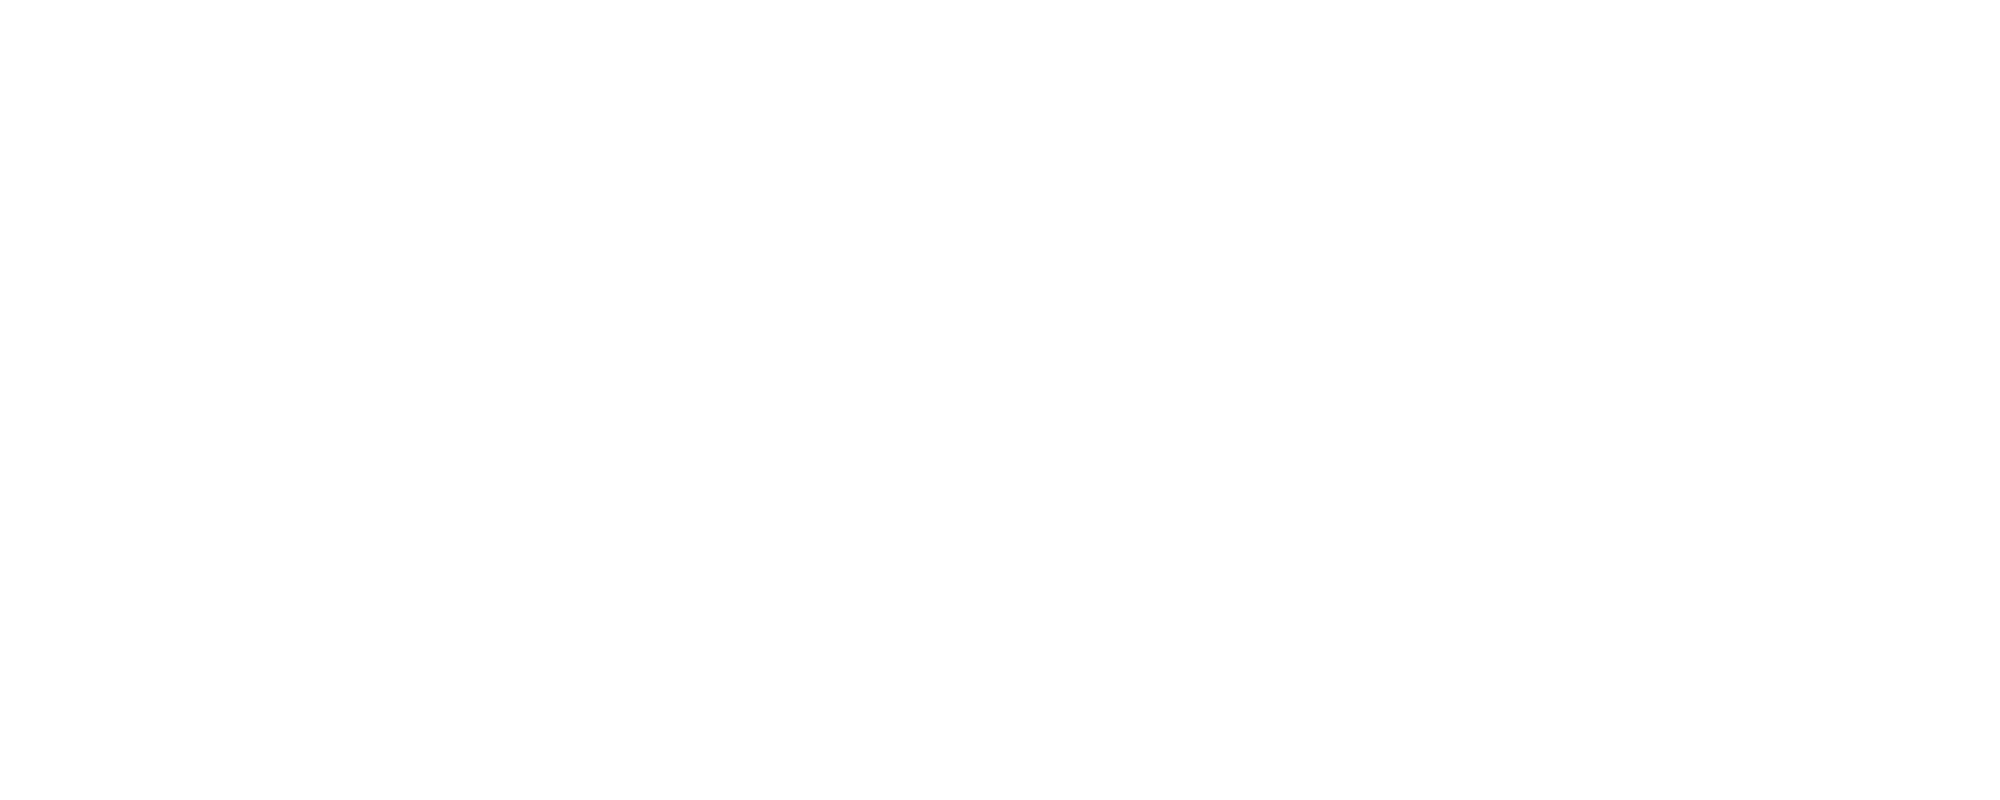

Calculated electrical order of the half-turns:
el_order_half_turns = [16, 304, 17, 305, 18, 306, 19, 307, 20, 308, 21, 309, 22, 310, 23, 311, 24, 312, 25, 313, 26, 314, 27, 315, 28, 316, 29, 317, 30, 318, 31, 319, 32, 320, 33, 321, 34, 322, 35, 323, 36, 324, 15, 303, 14, 302, 13, 301, 12, 300, 11, 299, 10, 298, 9, 297, 8, 296, 7, 295, 6, 294, 5, 293, 4, 292, 3, 291, 2, 290, 1, 289, 109, 397, 110, 398, 111, 399, 112, 400, 113, 401, 114, 402, 115, 403, 116, 404, 117, 405, 118, 406, 119, 407, 120, 408, 121, 409, 122, 410, 123, 411, 144, 432, 143, 431, 142, 430, 141, 429, 140, 428, 139, 427, 138, 426, 137, 425, 136, 424, 135, 423, 134, 422, 133, 421, 132, 420, 131, 419, 130, 418, 129, 417, 128, 416, 127, 415, 126, 414, 125, 413, 124, 412, 37, 325, 38, 326, 39, 327, 40, 328, 41, 329, 42, 330, 43, 331, 44, 332, 45, 333, 46, 334, 47, 335, 48, 336, 49, 337, 50, 338, 51, 339, 72, 360, 71, 359, 70, 358, 69, 357, 68, 356, 67, 355, 66, 354, 65, 353, 64, 352, 63, 351, 62, 350, 61, 349, 60, 348, 59,

In [10]:
# Start and end indices of each group
indexTstop = np.cumsum(nT)
indexTstop = indexTstop.tolist()
indexTstart = [1]
for i in range(len(nT)-1):
    indexTstart.extend([indexTstart[i] + nT[i]])

# # Fake electrical order
# el_order_half_turns = []
# for i in range(1,nHalfTurnsDefined+1):
#     el_order_half_turns.append(i)

# Calculation of the electrical order of the half-turns
# Pairs of groups whose half-turns are electrically connect (go and return lines)
elPairs_GroupTogether = [ [3,35], [4,36], [2,34], [1,33], [13,45], [14,46], [16,48], [15,47], [5,37], [6,38], [8,40], [7,39], [11,43], [12,44], [10,42], [9,41], [19,51], [20,52], [18,50], [17,49], [29,61], [30,62], [32,64], [31,63], [21,53], [22,54], [24,56], [23,55], [27,59], [28,60], [26,58], [25,57] ]
# For each pair of groups, this flag determines whether the half-turns are electrically connected following LEDET order, or its inverse
elPairs_RevElOrder = [ 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1 ]

nElPairs=len(elPairs_GroupTogether);

print('The half-turns of these pairs of groups will be connected electrically:')
print(elPairs_GroupTogether)

if len(elPairs_RevElOrder)!=nElPairs:
    raise Exception('Length of the vector elPairs_RevElOrder ({}) must be equal to nElPairs={}.'.format(len(elPairs_RevElOrder),nElPairs))

el_order_half_turns=[];
for p in range(nElPairs):
    if nT[elPairs_GroupTogether[p][0]-1]!=nT[elPairs_GroupTogether[p][1]-1]:
        raise Exception('Pair of groups defined by the variable elPairs_GroupTogether must have the same number of half-turns.')
    for k in range(nT[elPairs_GroupTogether[p][0]-1]):
        if elPairs_RevElOrder[p]==0:
            el_order_half_turns.append( indexTstart[elPairs_GroupTogether[p][0]-1]+k );
            el_order_half_turns.append( indexTstart[elPairs_GroupTogether[p][1]-1]+k );
        if elPairs_RevElOrder[p]==1:
            el_order_half_turns.append( indexTstop[elPairs_GroupTogether[p][0]-1]-k );
            el_order_half_turns.append( indexTstop[elPairs_GroupTogether[p][1]-1]-k );

el_order_half_turns_Array = np.int_(el_order_half_turns)
elPairs_GroupTogether_Array = np.int_(elPairs_GroupTogether)


# Plot
plt.figure(figsize=(20,8))
plt.subplot(1, 3, 1)
plt.scatter(x_ave, y_ave, s=2, c=np.argsort(el_order_half_turns_Array))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the half-turns',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Electrical order [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
# Plot
plt.subplot(1, 3, 2)
plt.plot(x_ave[el_order_half_turns_Array-1],y_ave[el_order_half_turns_Array-1],'k')
plt.scatter(x_ave, y_ave, s=2, c=nS)
plt.scatter(x_ave[el_order_half_turns_Array[0]-1], y_ave[el_order_half_turns_Array[0]-1], s=50, c='b', label='Positive lead')
plt.scatter(x_ave[el_order_half_turns_Array[-1]-1], y_ave[el_order_half_turns_Array[-1]-1], s=50, c='r', label='Negative lead')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the half-turns',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
plt.legend(loc='lower left')
# Plot
plt.subplot(1, 3, 3)
plt.plot(x_ave_group[elPairs_GroupTogether_Array[:,0]-1],y_ave_group[elPairs_GroupTogether_Array[:,0]-1],'b')
plt.scatter(x, y, s=2, c='k')
plt.scatter(x_ave_group, y_ave_group, s=10, c='r')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the groups (only go-lines)',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

print('Calculated electrical order of the half-turns:')
print('el_order_half_turns = {}'.format(el_order_half_turns))

<img src="MQM_electricalOrder.png" width="750"/>

# Cable geometry parameters (NOT DONE AUTOMATICALLY - PLACEHOLDER)

In [11]:
# Inclination of cables with respect to X axis (including transformations for mirror and rotation)
alphasDEG = nHalfQuadrants * [0, 0.8464, 1.6928, 2.5392, 3.3856, 4.232, 5.0784, 5.9248, 6.7712, 7.6176, 27.442, 28.2884, 29.1348, 29.9812, 30.8276, 0, 0.8464, 1.6928, 2.5392, 3.3856, 4.232, 5.0784, 5.9248, 6.7712, 7.6176, 8.464, 9.3104, 10.1568, 24.708, 25.5544, 26.4008, 27.2472, 28.0936, 28.94, 29.7864, 30.6328 ]
# Rotate cable by a certain angle [deg]
rotation_block = 4* ( int(nHalfTurnsDefined/16) *[0] + int(nHalfTurnsDefined/16) *[90] + int(nHalfTurnsDefined/16) *[180] + int(nHalfTurnsDefined/16) *[270] )
# Mirror cable along the bisector of its quadrant (0=no, 1=yes)
mirror_block = int(nHalfTurnsDefined/2) * [0] + int(nHalfTurnsDefined/2) * [1]
# Mirror cable along the Y axis (0=no, 1=yes)
mirrorY_block = nHalfTurnsDefined * [0]

# Heat exchange between half-turns along the cable wide side

In [12]:
# Pairs of half-turns exchanging heat along the cable wide side
iContactAlongWidth_From = []
iContactAlongWidth_To = []

for g in range(nGroupsDefined):
    iContactAlongWidth_From.extend( range(indexTstart[g], indexTstop[g]) )
    iContactAlongWidth_To.extend( range(indexTstart[g]+1, indexTstop[g]+1) )

print('Heat exchange along the cable wide side - Calculated indices:')
print('iContactAlongWidth_From = ')
print(iContactAlongWidth_From)
print('iContactAlongWidth_To = ')
print(iContactAlongWidth_To)

Heat exchange along the cable wide side - Calculated indices:
iContactAlongWidth_From = 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 209, 210, 211, 212, 213, 214, 215, 217, 218, 219, 220, 221, 222, 223, 224, 225, 227

# Heat exchange between half-turns along the cable narrow side

In [13]:
# This code will automatically find the half-turns that touch along the cable narrow side
# Half-turns will be thermally linked if:
# - they do not belong to the same conductor group, and
# - at least one strand of one half-turn is closer than max_distance to at least one strand of the other half-turn
# The code eliminates double repetition and orders the indices

# Prepare input for the function close_pairs_ckdtree
max_distance = 0.95E-3
X = np.column_stack((x, y))

# find all pairs of strands closer than a distance of max_d
pairs_close = close_pairs_ckdtree(X, max_distance)

# find pairs that belong to half-turns located in different groups
contact_pairs = set([])
for p in pairs_close:
    if not strandToGroup[p[0]] == strandToGroup[p[1]]:
        contact_pairs.add((strandToHalfTurn[p[0]],strandToHalfTurn[p[1]]))

# assign the pair values to two distinct vectors
iContactAlongHeight_From = []
iContactAlongHeight_To = []
for p in contact_pairs:
    iContactAlongHeight_From.append(p[0])
    iContactAlongHeight_To.append(p[1])

# find indices to order the vector iContactAlongHeight_From
idxSort = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(iContactAlongHeight_From))]

# reorder both iContactAlongHeight_From and iContactAlongHeight_To using the indices
iContactAlongHeight_From = [iContactAlongHeight_From[i] for i in idxSort]
iContactAlongHeight_To = [iContactAlongHeight_To[i] for i in idxSort]

print('Heat exchange along the cable narrow side - Calculated indices:')
print('iContactAlongHeight_From = ')
print(iContactAlongHeight_From)
print('iContactAlongWidth_To = ')
print(iContactAlongHeight_To)


# Plot
iContactAlongHeight_From_Array = np.int_(iContactAlongHeight_From)
iContactAlongHeight_To_Array = np.int_(iContactAlongHeight_To)
iContactAlongWidth_From_Array = np.int_(iContactAlongWidth_From)
iContactAlongWidth_To_Array = np.int_(iContactAlongWidth_To)

%matplotlib notebook
plt.figure(figsize=(10,10))
# plot strand positions
plt.scatter(x, y, s=2, c='b')
# plot conductors
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)
# plot average conductor positions
plt.scatter(x_ave, y_ave, s=10, c='r')
# plot heat exchange links along the cable narrow side
for i in range(len(iContactAlongHeight_From)):
    plt.plot([x_ave[iContactAlongHeight_From_Array[i]-1],x_ave[iContactAlongHeight_To_Array[i]-1]], [y_ave[iContactAlongHeight_From_Array[i]-1],y_ave[iContactAlongHeight_To_Array[i]-1]] ,'k')
# plot heat exchange links along the cable wide side
for i in range(len(iContactAlongWidth_From)):
    plt.plot([x_ave[iContactAlongWidth_From_Array[i]-1],x_ave[iContactAlongWidth_To_Array[i]-1]], [y_ave[iContactAlongWidth_From_Array[i]-1],y_ave[iContactAlongWidth_To_Array[i]-1]] ,'r')
# plot strands belonging to different conductor groups and closer to each other than max_distance
# for p in pairs_close:
#     if not strandToGroup[p[0]] == strandToGroup[p[1]]:
#         plt.plot([X[p[0], 0], X[p[1], 0]], [X[p[0], 1], X[p[1], 1]], c='g')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Heat exchange order of the half-turns',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

Heat exchange along the cable narrow side - Calculated indices:
iContactAlongHeight_From = 
[1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 8, 8, 9, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 37, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 42, 43, 44, 44, 45, 46, 47, 47, 48, 48, 49, 49, 50, 50, 51, 51, 52, 73, 73, 73, 74, 74, 75, 75, 76, 76, 77, 77, 78, 79, 80, 80, 81, 82, 83, 83, 84, 84, 85, 85, 86, 86, 87, 87, 88, 109, 109, 109, 110, 110, 111, 111, 112, 112, 113, 113, 114, 115, 116, 116, 117, 118, 119, 119, 120, 120, 121, 121, 122, 122, 123, 123, 124, 145, 145, 145, 146, 146, 147, 147, 148, 148, 149, 149, 150, 151, 152, 152, 153, 154, 155, 155, 156, 156, 157, 157, 158, 158, 159, 159, 160, 181, 181, 181, 182, 182, 183, 183, 184, 184, 185, 185, 186, 187, 188, 188, 189, 190, 191, 191, 192, 192, 193, 193, 194, 194, 195, 195, 196, 217, 217, 217, 218, 218, 219, 219, 220, 220, 221, 221, 222, 223, 224, 224, 225, 226, 227, 227, 228, 228, 229, 229, 230, 230, 231, 231, 232, 253, 253, 253, 254, 254, 25

<IPython.core.display.Javascript object>

(-0.15797572543136154,
 0.1579757254313616,
 -0.05128224254455224,
 0.051282242544552215)

# Quench initiation calculation: Force selected half-turns to quench

In [14]:
# Choose one of the two following options: Fully 2D model, or Experimental 2D+1D model

# # # # Fully 2D model
# # Indices of the half-turns that are set to quench at a given time
# iStartQuench = [100]
# # Time at which each selected half-turn quenches [s]
# tStartQuench = [-0.015]
# # Length of the initial hot-spot [m] (it can be set to a large value to implement a full 2D model)
# lengthHotSpot_iStartQuench = [l_magnet]
# # Quench propagation velocity [m/s] (you can write 2x higher velocity if the quench propagates in two directions)
# vQ_iStartQuench = [99999]

# # # Experimental 2D + 1D model
# In this example, only one half-turn is quenched (#100). When it quenches at time tStartQuench, the half-turn electrical resistance will be calculated using an initial quenched length of lengthHotSpot_iStartQuench, increasing with velocity vQ_iStartQuench
# When the quench propagates to the three adjacent half-turns (#97-99), their resistances will also be calculated using an initial quenched length of lengthHotSpot_iStartQuench, increasing with velocity vQ_iStartQuench
# When any other half-turn in the model quenches, its resistance will be calculated using the full magnetic length.
# Indices of the half-turns that are set to quench at a given time
iStartQuench = list(range(1, nHalfTurnsDefined+1))
# Time at which each selected half-turn quenches [s]
tStartQuench = [9999]*nHalfTurnsDefined
# Length of the initial hot-spot [m] (it can be set to a large value to implement a full 2D model)
lengthHotSpot_iStartQuench = [10E-3]*nHalfTurnsDefined
# Quench propagation velocity [m/s] (you can write 2x higher velocity if the quench propagates in two directions)
#vQ_iStartQuench = [99999]*(len(CondNumbers))
paramLEDET.localsParser(locals())
paramLEDET.adjust_vQ(nameMagnet+'_All_WithIron_WithSelfField.map2d')
vQ_iStartQuench = paramLEDET.getAttribute("Inputs","vQ_iStartQuench")

##### Plotting
vQ_iStartQuench_Plot = vQ_iStartQuench
fig, ax = plt.subplots()
plt.scatter(x_ave*1000, y_ave*1000, s=2, c=vQ_iStartQuench_Plot)
plt.xlabel('x [mm]',**selectedFont)
plt.ylabel('y [mm]',**selectedFont)
plt.title('2D cross-section Quench propagation velocity',**selectedFont)
plt.set_cmap('jet')
plt.grid('minor',alpha=0.5)
cbar = plt.colorbar()
cbar.set_label('Quench velocity [m/s]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
print(max(vQ_iStartQuench_Plot))

Field maps: 100%|██████████| 1/1 [00:40<00:00, 40.68s/it]


<IPython.core.display.Javascript object>

42.6196040383805


# Electrical circuit during powering transient
<img src="../resources/LEDET_CircuitSchematic_Powering.png" width="750"/>


# Electrical circuit during protection transient
<img src="../resources/LEDET_CircuitSchematic_Protection.png" width="750"/>

# Circuit warm resistance and power-supply crowbar

In [15]:
# Resistance of the warm parts of the circuit [Ohm]
R_circuit = 0.000
# Resistance of crowbar of the power supply [Ohm]
R_crowbar = 0.000
# Forward voltage drop of a diode or thyristor in the crowbar of the power supply [V]
Ud_crowbar = 0.000

# Power supply control

In [16]:
# Time when the power supply is switched off and the crowbar is switched on [s]
t_PC = 0
# LUT controlling power supply, Time [s]
t_PC_LUT = [-0.02, t_PC, t_PC+0.01]
# LUT controlling power supply, Current [A]
I_PC_LUT = [I00, I00, 0]

# Plot
plt.figure(figsize=(5,5))
plt.plot([t_PC,t_PC], [np.min(I_PC_LUT),np.max(I_PC_LUT)], 'k--', linewidth=4.0, label='t_PC')
plt.plot(t_PC_LUT, I_PC_LUT, 'ro-', label='LUT')
plt.xlabel('Time [s]',**selectedFont)
plt.ylabel('Current [A]',**selectedFont)
plt.title('Look-up table controlling power supply',**selectedFont)
plt.grid(True)
plt.rcParams.update({'font.size': 12})

<IPython.core.display.Javascript object>

# Energy-extraction system

In [17]:
# Time when the energy-extraction system is triggered [s]
tEE = 99999
# Resistance of the energy-extraction system [Ohm]
R_EE_triggered = 0.066

# CLIQ system

In [18]:
# Time when the CLIQ system is triggered [s]
tCLIQ = 99999
# Direction of the introduced current change for the chosen CLIQ configuration
directionCurrentCLIQ = [1, 1]
# Number of CLIQ units
nCLIQ = 1
# CLIQ charging voltage [V]
U0 = 1000
# Capacitance of the CLIQ capacitor bank [F]
C = 0.04
# Resistance of the CLIQ leads [Ohm]
Rcapa = 0.05

# Quench heater parameters

In [19]:
# Number of quench heater strips to write in the file
nHeaterStrips = 16

# Time at which the power supply connected to the QH strip is triggered (Low-field QHs set to a very large value to avoid triggering).
tQH = nHeaterStrips * [.002]
# Charging voltage of the capacitor connected to the QH strip.
U0_QH = nHeaterStrips * [900/8]
# Capacitance of the capacitor connected to the QH strip.
C_QH = nHeaterStrips * [7.05E-3*8]
# Resistance of the warm leads of the QH strip discharge circuit.
R_warm_QH = nHeaterStrips * [0.175] # 0.125-->0.175 Ohm partially compensates the fact that the real strip is 3.491 m long instead of l_magnet=3.400 m long
# Width of the non-Cu-plated part of the the QH strip.
w_QH = nHeaterStrips * [21E-3]
# Height of the non-Cu-plated part of the QH strip.
h_QH = nHeaterStrips * [25E-6]
# Thickness of the insulation layer between QH strip and coil insulation layer.
s_ins_QH = nHeaterStrips * [75E-6]
# Type of materialof the insulation layer between QH strip and coil insulation layer (1=G10; 2=kapton)
type_ins_QH = nHeaterStrips * [2]
# Thickness of the insulation layer between QH strip and the helium bath (or the collars); on this side, the QH strip is thermally connected to an infinite thermal sink at constant temperature.
s_ins_QH_He = nHeaterStrips * [500E-6]
# Type of material of the insulation layer between QH strip and helium bath (1=G10; 2=kapton)
type_ins_QH_He = nHeaterStrips * [2]
# Length of the QH strip
l_QH = nHeaterStrips * [l_magnet]
# Fraction of QH strip covered by heating stations (not-Cu-plated).
f_QH = nHeaterStrips * [0.125/(0.125+0.100)]

In [20]:
# The following lines do not affect the generated LEDET input file, and are only used to debug this notebook
# Calculate QH strip resistance
rhoSS = 5.00E-07 * 1.09 # in [Ohm m]
R_cold_QH, R_total_QH, I0_QH, tau_QH = [], [], [], []
for qh in range(len(tQH)):
    R_cold_QH.append(rhoSS / (w_QH[qh] * h_QH[qh]) * l_QH[qh] * f_QH[qh])
    R_total_QH.append(R_cold_QH[qh] + R_warm_QH[qh])
    I0_QH.append(U0_QH[qh] / R_total_QH[qh])
    tau_QH.append(R_total_QH[qh] * C_QH[qh])
 
print('I0_QH={}'.format(I0_QH))
print('tau_QH={}'.format(tau_QH))
print(R_warm_QH[qh])


I0_QH=[72.15576482565538, 72.15576482565538, 72.15576482565538, 72.15576482565538, 72.15576482565538, 72.15576482565538, 72.15576482565538, 72.15576482565538, 72.15576482565538, 72.15576482565538, 72.15576482565538, 72.15576482565538, 72.15576482565538, 72.15576482565538, 72.15576482565538, 72.15576482565538]
tau_QH=[0.0879347619047619, 0.0879347619047619, 0.0879347619047619, 0.0879347619047619, 0.0879347619047619, 0.0879347619047619, 0.0879347619047619, 0.0879347619047619, 0.0879347619047619, 0.0879347619047619, 0.0879347619047619, 0.0879347619047619, 0.0879347619047619, 0.0879347619047619, 0.0879347619047619, 0.0879347619047619]
0.175


# Electrical circuit during powering transient
<img src="MQM_QH_positions.png" width="750"/>

# Heat exchange between quench heater strips and half-turns - QH POSITIONS ONLY GUESSED

In [21]:
# Thermal connections between heater strips and half-turns are manually defined for one half-quadrant and then automatically extended to the other half-quadrants
iQH_toHalfTurn_From_oneHalfQuadrant = 18*[1]
iQH_toHalfTurn_To_oneHalfQuadrant = list(range(17,34+1))

nHalfTurnsinHQ = sum(nT[0:4])


# Automatically extend to the other half-quadrants
iQH_toHalfTurn_To=[]
iQH_toHalfTurn_From=[]
for i in range (0,nHalfQuadrants):
    iQH_tempVector_To = list(np.asarray(iQH_toHalfTurn_To_oneHalfQuadrant) + i*nHalfTurnsinHQ)
    iQH_toHalfTurn_To.extend(iQH_tempVector_To)
    
    iQH_tempVector_From = list(np.asarray(iQH_toHalfTurn_From_oneHalfQuadrant) + i)
    iQH_toHalfTurn_From.extend(iQH_tempVector_From)
    
# Plot
iQH_toHalfTurn_From_Array = np.int_(iQH_toHalfTurn_From)
iQH_toHalfTurn_To_Array = np.int_(iQH_toHalfTurn_To)

f = plt.figure(figsize=(10,10))
plt.scatter(x, y,s=1, c='k')
plt.scatter(x_ave[iQH_toHalfTurn_To_Array-1], y_ave[iQH_toHalfTurn_To_Array-1], s=10, c=iQH_toHalfTurn_From_Array)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Heat exchange between half-turns and QH',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('QH strip number [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')


print ('iQH_toHalfTurn_From = {}'.format(iQH_toHalfTurn_From))
print ('iQH_toHalfTurn_To = {}'.format(iQH_toHalfTurn_To))

<IPython.core.display.Javascript object>

iQH_toHalfTurn_From = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,

<img src="MBM_QH_positions.png" width="750"/>

# Adiabatic hot-spot temperature calculation

In [22]:
# Time from which the adiabatic hot-spot temperature calculation starts. For each coil section, calculate the adiabatic hot-spot temperature in the highest-field strand/cable [s]
tQuench = nCoilSectionsDefined * [-0.015]
# Initial quench temperature in the hot-spot temperature calculation [K]
initialQuenchTemp = nCoilSectionsDefined * [10]

# Self-mutual inductance matrix between half-turns, and between coil sections

In [23]:
# Self-mutual inductance calculation, using SMIC (https://cernbox.cern.ch/index.php/s/37F87v3oeI2Gkp3)
flag_strandCorrection = 0
flag_sumTurnToTurn = 1
flag_writeOutput = 0

# Calculate group to which each half-turn belongs
indexTstart = np.hstack([1, 1+np.cumsum(nT[:-1])]);
indexTstop = np.cumsum(nT);
HalfTurnToGroup = np.zeros((1, nHalfTurnsDefined), dtype=int)
HalfTurnToGroup = HalfTurnToGroup[0]
HalfTurnToCoilSection = np.zeros((1, nHalfTurnsDefined), dtype=int)
HalfTurnToCoilSection = HalfTurnToCoilSection[0]
for g in range(1,nGroupsDefined+1):
    HalfTurnToGroup[indexTstart[g-1]-1:indexTstop[g-1]] = g
    HalfTurnToCoilSection[indexTstart[g-1]-1:indexTstop[g-1]]=GroupToCoilSection[g-1]

# Calculate group to which each strand belongs
indexSstart = np.hstack([1, 1+np.cumsum(nS[:-1])]);
indexSstop = np.cumsum(nS);
strandToGroup = np.zeros((1, nStrands), dtype=int)
strandToGroup = strandToGroup[0]
strandToCoilSection = np.zeros((1, nStrands), dtype=int)
strandToCoilSection = strandToCoilSection[0]
for ht in range(1,nHalfTurnsDefined+1):
    strandToGroup[indexSstart[ht-1]-1:indexSstop[ht-1]] = HalfTurnToGroup[ht-1]
    strandToCoilSection[indexSstart[ht-1]-1:indexSstop[ht-1]]=HalfTurnToCoilSection[ht-1]

# Calculate diameter of each strand
Ds = np.zeros((1, nStrands), dtype=float)
Ds = Ds[0]
for g in range(1,nGroupsDefined+1):
    Ds[np.where(strandToGroup==g)] = ds_inGroup[g-1]


# Define self-mutual inductance calculation object
coil = SelfMutualInductanceCalculation(x, y, polarities, nS, Ds, strandToHalfTurn, strandToCoilSection, flag_strandCorrection, flag_sumTurnToTurn, flag_writeOutput, nameMagnet)

# Calculate self-mutual inductance between half-turns, turns, and coil-sections, per unit length [H/m]
M_halfTurns_calculated, M_turns_calculated, M_coilSections_calculated, L_mag0_calculated = coil.calculateInductance(x, y, polarities, nS, Ds, strandToHalfTurn, strandToCoilSection, flag_strandCorrection=0)

# Self-mutual inductances between coil sections, per unit length [H/m]
M_m = M_coilSections_calculated
# Self-mutual inductances between turns, per unit length [H/m]
M_InductanceBlock_m = M_turns_calculated
# Total magnet self-mutual inductance, per unit length [H/m]
L_mag0 = L_mag0_calculated

print('')
print('Total magnet self-inductance per unit length: ' + str(L_mag0) + ' H/m')

# Defining to which inductive block each half-turn belongs
HalfTurnToInductanceBlock = range(1, int(nHalfTurnsDefined/2+1))
HalfTurnToInductanceBlock = []
for i in range(2):
    for j in range(1, int(nHalfTurnsDefined/2+1)):
        HalfTurnToInductanceBlock.append(j)

Self-mutual inductance between strands - Calculation started
Calculation does not include correction for strand diameter.
Status: [------------------->] 100%
Self-mutual inductance between strands - Calculation finished
Self-mutual inductance between half-turns - Calculation started
Self-mutual inductance between half-turns - Calculation finished
Self-mutual inductance between turns - Calculation started
Self-mutual inductance between turns - Calculation finished

Total magnet self-inductance per unit length: 0.008174623706000039 H/m


In [24]:
# Plot half-turn and strand properties
f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x_ave, y_ave, s=2, c=HalfTurnToGroup)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('HalfTurnToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x_ave, y_ave, s=2, c=HalfTurnToCoilSection)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('HalfTurnToCoilSection',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Coil section [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x, y, s=2, c=strandToGroup)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('StrandToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x, y, s=2, c=strandToCoilSection)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('StrandToCoilSection',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Coil Section [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

<IPython.core.display.Javascript object>

# Differential inductance versus current (Iron-yoke effect) - IMPORT FROM ROXIE

In [25]:
# Copy/paste the values after calculation using ROXIE or COMSOL or another software
fL_I = [0, 99.9, 499.905, 899.91, 1299.915, 1699.92, 2099.925, 2499.93, 2899.935, 3299.94, 3699.945, 4099.95, 4499.955, 4899.96, 5299.965, 5699.97, 6899.985, 7299.99, 7699.995, 8100 ]
fL_L = [1.08482174335328, 1.08482174335328, 1.08482174335328, 1.08479627062114, 1.08471164531912, 1.08459620269645, 1.08442991491992, 1.08432952864778, 1.08433095011994, 1.08475355672842, 1.08432125915399, 1.08407791706614, 1.08346682227087, 1.08283063029592, 1.08164744188899, 1.07988509899491, 1.07039336056259, 1.04782133564301, 1.03460886325475, 1.03131164114773 ]


# Plot
f = plt.figure(figsize=(7.5,5))
plt.plot(fL_I, fL_L, 'ro-')
plt.xlabel('Current [A]',**selectedFont)
plt.ylabel('Factor scaling nominal inductance [-]',**selectedFont)
plt.title('Differential inductance versus current',**selectedFont)
plt.xlim([0, I00*2])
plt.grid(True)
plt.rcParams.update({'font.size': 12})

<IPython.core.display.Javascript object>

# Time Vector Definition

In [26]:
# Time Vector Definition. Parameters used to generate the time vector.
# Each triplet of numbers defines a time window: first element is the start time, second element is the time step in that window, third element is the end time. It must contain a number of elements multiple of 3. Any time point above t=1000 s will be ignored.
time_vector_params = [-0.02, 2.50E-05, -0.001, -0.000975, 2.50E-05, 0.04, 0.0405, 5.00E-04, 1]

# Plot
f = plt.figure(figsize=(7.5,5))
plt.plot([t_PC,t_PC], [0,1], 'k--', linewidth=4.0, label='t_PC')
plt.plot([tEE,tEE], [0,1], 'r--', linewidth=4.0, label='t_EE')
plt.plot([tCLIQ,tCLIQ], [0,1], 'g--', linewidth=4.0, label='t_CLIQ')
plt.plot([np.min(tQH),np.min(tQH)], [0,1], 'b:', linewidth=2.0, label='t_QH')
plt.xlabel('Time [s]',**selectedFont)
plt.ylabel('Trigger [-]',**selectedFont)
plt.xlim([1E-4,time_vector_params[-1]])
plt.title('Power suppply and quench protection triggers',**selectedFont)
plt.grid(True)
plt.rcParams.update({'font.size': 12})
plt.legend(loc='best')

<IPython.core.display.Javascript object>

# Options - Change something only if you know what you're doing

In [27]:
# Field-Map Files Options
Iref = Iref # Note: slightly different from I_nominal=5390 A
flagIron = 1
flagSelfField = 1
headerLines = 1
columnsXY = [4, 5]
columnsBxBy = [6, 7]
flagPlotMTF = 0

# Input Generation Options
flag_calculateInductanceMatrix = 0
flag_useExternalInitialization = 0
flag_initializeVar = 0

# Simulation Run Options
flag_fastMode = 1
flag_controlCurrent = 0
flag_automaticRefinedTimeStepping = 1

# Simulation Physics Options
flag_IronSaturation = 1
flag_InvertCurrentsAndFields = 0
flag_ScaleDownSuperposedMagneticField = 1
flag_HeCooling = 2
fScaling_Pex = 1
fScaling_Pex_AlongHeight = fScaling_Pex_AlongHeight_Defined
fScaling_MR = 1
flag_scaleCoilResistance_StrandTwistPitch = 2
flag_separateInsulationHeatCapacity = 0
flag_ISCL = 1
fScaling_Mif = 1
fScaling_Mis = 1
flag_StopIFCCsAfterQuench = 0
flag_StopISCCsAfterQuench = 0
tau_increaseRif = 0.005
tau_increaseRis = 0.01
fScaling_RhoSS = 1.09
maxVoltagePC = 10
flag_symmetricGroundingEE = 0
flag_removeUc = 0
BtX_background = 0
BtY_background = 0

# Post-Processing Options
flag_showFigures = 0
flag_saveFigures = 0
flag_saveMatFile = 1
flag_saveTxtFiles = 0
flag_generateReport = 1
flag_hotSpotTemperatureInEachGroup = 1
MinMaxXY_MTF = [-160, 160, -60, 60]

# Adjust quench velocity based on Quench Heater

In [28]:
paramLEDET.localsParser(locals())
[tbi, th_con_w, th_con_h] = paramLEDET._obtainThermalConnections()
paramLEDET.adjust_vQ_QuenchHeater(th_con_h, th_con_w, 11) # 11 =  Number of heating stations
vQ_iStartQuench = paramLEDET.Inputs.vQ_iStartQuench
lengthHotSpot_iStartQuench = paramLEDET.Inputs.lengthHotSpot_iStartQuench

# Define the values of all Plots variables - Change something only if you know what you're doing

In [29]:
# Define the values of all Plots variables
suffixPlot = []
typePlot = []
outputPlotSubfolderPlot = []
variableToPlotPlot = []
selectedStrandsPlot = []
selectedTimesPlot = []
labelColorBarPlot = []
minColorBarPlot = []
maxColorBarPlot = []
MinMaxXYPlot = []
flagSavePlot = []
flagColorPlot = []
flagInvisiblePlot = []

# Define the values of all Variables variables - Change something only if you know what you're doing

In [30]:
# Define the values of all Variables variables
variableToSaveTxt = ['time_vector', 'Ia', 'Ib', 'T_ht', 'dT_dt_ht', 'flagQ_ht', 'IifX', 'IifY', 'Iis', 'dIifXDt', 'dIifYDt', 'dIisDt', 'Uc', 'U_QH', 'T_s_QH', 'time_vector', 'R_CoilSections', 'U_inductive_dynamic_CoilSections']
typeVariableToSaveTxt = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1]
variableToInitialize = ['Ia', 'Ib', 'T_ht', 'dT_dt_ht', 'flagQ_ht', 'IifX', 'IifY', 'Iis', 'dIifXDt', 'dIifYDt', 'dIisDt', 'Uc', 'U_QH', 'T_s_QH']

# Add all Inputs, Options, Plots, and Variables variables to a list - DO NOT CHANGE

In [31]:
paramLEDET.localsParser(locals())

# Visualize the defined variables

In [32]:
if verbose:
    # Visualize variable descriptions, names, and values
    print('### "Inputs" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupInputs, paramLEDET.variablesInputs)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Options" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupOptions, paramLEDET.variablesOptions)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Plots" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupPlots, paramLEDET.variablesPlots)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Variables" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupVariables, paramLEDET.variablesVariables)

### "Inputs" variables ###
Initial temperature [K]
T00 1.9
Magnetic length [m]
l_magnet 2.4
Initial current [A]
I00 5390
Define the coil section where each group of cables is located
GroupToCoilSection [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Polarity of the current in each group of strands
polarities_inGroup [ 1  1  1  1 -1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1
  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1  1
 -1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1  1]
Number of half-turns in each group
nT [10  5 13  8 10  5 13  8 10  5 13  8 10  5 13  8 10  5 13  8 10  5 13  8
 10  5 13  8 10  5 13  8 10  5 13  8 10  5 13  8 10  5 13  8 10  5 13  8
 10  5 13  8 10  5 13  8 10  5 13  8 10  5 13  8]
Number of strands in each cable belonging to a particular group
nStrands_inGroup [36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36

# Write the LEDET input file

In [33]:
nameFileLEDET = nameMagnet + '_0' +'.xlsx'
paramLEDET.writeFileLEDET(nameFileLEDET)

Persistent current parameters are set but flag is not. Continuing.
Preliminary consistency check was successful! -  MQMC_2in1_0.xlsx

### Write "Variables" sheet ###

### Write "Plots" sheet ###

### Write "Options" sheet ###
### Write "Inputs" sheet ###
 
Time stamp: 2021-08-31 14:49:44.189556
New file MQMC_2in1_0.xlsx generated.


# Persistent Currents - Edit simulation options and input 


In [34]:
# This cell write an input file for simulating a powering cycle
# Define input parameters 
I00 = 5390
I_PC_LUT = [0, 0, I00, I00, 0, 0, I00, I00, 0]
dIdt = 16.167 
timeStep = 0.25  # Coarse time step

# Write input file to LEDET
nameFileLEDET_PS = nameMagnet + '_200' + '.xlsx'
PS_paramLEDET = deepcopy(paramLEDET)
PS_paramLEDET.localsParser(locals())
PS_paramLEDET.preparePersistentCurrents(I_PC_LUT, dIdt, timeStep)
PS_paramLEDET.writeFileLEDET(nameFileLEDET_PS)

<IPython.core.display.Javascript object>

Preliminary consistency check was successful! -  MQMC_2in1_200.xlsx

### Write "Variables" sheet ###

### Write "Plots" sheet ###

### Write "Options" sheet ###
### Write "Inputs" sheet ###
 
Time stamp: 2021-08-31 14:49:47.154135
New file MQMC_2in1_200.xlsx generated.
